In [1]:
import duckdb

In [5]:
duckdb.sql("""
CREATE OR REPLACE TABLE titanic AS
SELECT * FROM read_csv_auto('data/titanic_cleaned_day2.csv', HEADER=True)
""")

In [9]:
duckdb.sql("""
ALTER TABLE titanic ADD COLUMN AgeGroup VARCHAR;
UPDATE titanic
SET AgeGroup = CASE 
    WHEN Age <16 THEN 'Child'
    WHEN Age >16 AND Age <60 THEN 'Adult'
    ELSE 'Senior'
END;
""")

In [13]:
duckdb.sql("""
SELECT 
    t.*,
    AVG(Survived) OVER(PARTITION BY Sex) AS Sex_Survival_Rate,
    AVG(Survived) OVER(PARTITION BY Pclass) AS Pclass_Survival_Rate,
    AVG(Survived) OVER(PARTITION BY AgeGroup) AS AgeGroup_Survival_Rate
FROM titanic t
LIMIT 5;
""").df()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,fare_per_person,is_child,family_size_1,fare_per_person_1,is_child_1,imputed_age,AgeGroup,Sex_Survival_Rate,Pclass_Survival_Rate,AgeGroup_Survival_Rate
0,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.000,...,9.67,1,3,9.67,1,0.83,Child,0.188908,0.472826,0.590361
1,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.00,0,2,315153,22.025,...,7.34,1,3,7.34,1,4.00,Child,0.742038,0.242363,0.590361
2,194,1,2,"Navratil, Master. Michel M",male,3.00,1,1,230080,26.000,...,8.67,1,3,8.67,1,3.00,Child,0.188908,0.472826,0.590361
3,341,1,2,"Navratil, Master. Edmond Roger",male,2.00,1,1,230080,26.000,...,8.67,1,3,8.67,1,2.00,Child,0.188908,0.472826,0.590361
4,408,1,2,"Richards, Master. William Rowe",male,3.00,1,1,29106,18.750,...,6.25,1,3,6.25,1,3.00,Child,0.188908,0.472826,0.590361


In [15]:
median_fare= duckdb.sql('SELECT median(Fare) FROM titanic'). fetchone()[0]

In [20]:
duckdb.sql(f"""
ALTER TABLE titanic ADD COLUMN High_Fare INTEGER;
UPDATE titanic
SET High_Fare = CASE
    WHEN Fare > {median_fare} THEN 1
    ELSE 0
    END;
""")

In [21]:
duckdb.sql("""ALTER TABLE titanic ADD COLUMN FareGroup VARCHAR;""")

In [22]:
duckdb.sql(f"""
UPDATE titanic
SET FareGroup= CASE
    WHEN Fare <= {median_fare} THEN 'Low'
    ELSE 'High'
    END;
    """)

In [27]:
duckdb.sql("""
SELECT Fare, FareGroup
FROM titanic
ORDER BY Fare
LIMIT 5;""").df()

,Fare,FareGroup
0,0.0,Low
1,0.0,Low
2,0.0,Low
3,0.0,Low
4,0.0,Low


In [31]:
duckdb.sql("""
SELECT 
    FareGroup,
    Pclass,
    COUNT(*) AS total_passengers,
    AVG(Survived) AS survival_rate
FROM titanic
GROUP BY FareGroup, Pclass
ORDER BY FareGroup, Pclass;
""").df()

,FareGroup,Pclass,total_passengers,survival_rate
0,High,1,210,0.647619
1,High,2,92,0.586957
2,High,3,142,0.281690
3,Low,1,6,0.000000
4,Low,2,92,0.358696
5,Low,3,349,0.226361


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
fare_pclass_df = duckdb.sql("""
    SELECT 
        FareGroup,
        Pclass,
        COUNT(*) AS total_passengers,
        AVG(Survived) AS survival_rate
    FROM titanic
    GROUP BY FareGroup, Pclass
    ORDER BY FareGroup, Pclass;
""").df()

In [34]:
fare_pclass_df['Pclass'] = fare_pclass_df['Pclass'].astype(str)

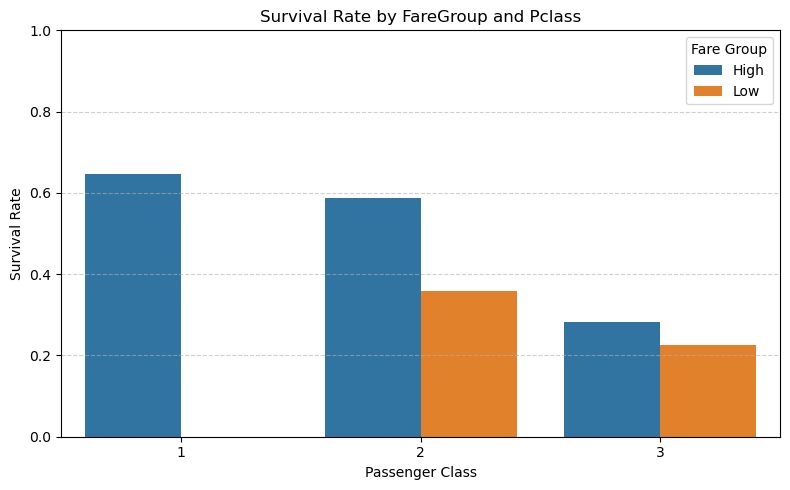

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fare_pclass_df, x="Pclass", y="survival_rate", hue="FareGroup")

plt.title("Survival Rate by FareGroup and Pclass")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)
plt.legend(title="Fare Group")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [38]:
duckdb.sql("""
COPY titanic TO 'data/titanic_enriched_day3.csv' (HEADER, DELIMITER ',');
""")

In [39]:
import os
os.listdir("data")

['titanic_enriched_day3.csv', 'titanic_cleaned_day2.csv']